In [1]:
import numpy as np
import pandas as pd
import spiceypy as spice
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import c
from astropy.time import Time
from astroquery.jplhorizons import Horizons
import rebound

In [2]:
def Furnisher():
    '''
    This function is used to load all kernels needed in an operation.
    Comment out kernels not in use and add the ones in use.
    
    Arguments: NA
    Returns: NA
    
    '''
    spice.kclear()
    spice.furnsh('/Users/user/Downloads/naif0009.tls.txt')
    #spice.furnsh('/Users/user/Downloads/cas00084.tsc.txt')
    #spice.furnsh('/Users/user/Downloads/cpck05Mar2004.tpc.txt')
    #spice.furnsh('/Users/user/Downloads/020514_SE_SAT105.bsp')
    #spice.furnsh('/Users/user/Downloads/981005_PLTEPH-DE405S.bsp')
    #spice.furnsh('/Users/user/Downloads/030201AP_SK_SM546_T45.bsp')
    #spice.furnsh('/Users/user/Downloads/04135_04171pc_psiv2.bc')
    #spice.furnsh('/Users/user/Downloads/cas_v37.tf.txt')
    #spice.furnsh('/Users/user/Downloads/cas_iss_v09.ti.txt')
    #spice.furnsh('/Users/user/Downloads/jup310.bsp')
    #spice.furnsh('/Users/user/Downloads/jup341.bsp')
    spice.furnsh('/Users/user/Downloads/de432s.bsp')
    pass

In [3]:
Furnisher()

In [4]:
def get_spice_function(name,cor,loc):
    """
    This wrapper function automates the creation of objects through the JPL Horizons database. 
    
    Arguments:
    
    name: str
    
    Stipulates the target object in Horizons. The major bodies in the Solar System have an id based on their position.
    Hence '5' refers to Jupiter and '3' to Earth. A single number designator refers to a barycenter and a designator
    such as '599' to the planetary center. For minor bodies in the Solar System, the id_type in the Horizons
    must be changed to "minorbody"
    
    cor: str
    
    Refers to the type of correction that the object has. Available arguments are 'NONE', 'LT','LT+S'
    
    loc: str
    
    Designates the location of observation. Names that start with "g@#" refer to barycenters where the number designates the 
    body that the observer is based at. Hence "g@0" refers to the Solar System barycenter. Also takes Earth location designators.
    Observatories are named after their code. Hence, Pan-Starrs observatory is referred as "f51"

    Returns:
    
    get_target_xyz function
    """    
    def get_target_xyz(t):
        """
        Returns the vectors of the Horizons body at a certain time t.
        
        Arguments:
        
        t: days
        
        Julian date of observation
        
        Returns:
    
        xyz: numpy array
        
        A position vector of the observed object
    
        uvw: numpy array
        
        An instantaneous velocity vector of the observed object
        
        radec: numpy array
        
        The right ascension and declination of the observed object
        """
        
        state,lighttime = spice.spkezr(name,t,'J2000',cor,loc)
        pos,lighttime = spice.spkpos(name,t,'J2000',cor,loc)
        range,ra,dec = spice.recrad(pos) 
        xyz = np.array([state[0],state[1],state[2]])/149597870.7#6.68459e-9
        uvw = np.array([state[3],state[4],state[5]])/149597870.7*24.*3600.#*6.68459e-9
        radec = np.array([ra,dec])
        return xyz,uvw,radec*180/np.pi
    return get_target_xyz

Starting the simulation

In [13]:
mj = 0.0009547919101638659#*0.9997929968806782
me = 3.0034896147890027e-06
mv = 2.4478382877865672e-06
mars = 3.2271560375546917e-07
mm = 1.6601141530544803e-07
ms = 0.00028588567270480304
mur = 4.3662496626890934e-05
mnept = 5.1513837726215274e-05
mio = 4.490855574220279e-08
meur = 2.4132928417702382e-08
mga = 7.450560006788226e-08
mcal = 5.409669859576579e-08
man = 0
mpl = 7.350487833457728e-09

In [6]:
def SimStart(bsolar,msolar,iJovian):
    t = 140961664.18440723
    sim = rebound.Simulation()
    k = 0.0172020989484
    sim.G = k**2
    sim.units = ('d', 'AU', 'Msun')
    get_sun = get_spice_function('Sun','NONE','SOLAR SYSTEM BARYCENTER')
    xyz,uvw,radec = get_sun(t) #Adding the Sun
    xyz = xyz
    uvw = (uvw*24*3600)
    sim.add(m=1,x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    for i in range(0,len(bsolar)):
        get_planet = get_spice_function(bsolar[i],'NONE','SOLAR SYSTEM BARYCENTER')
        xyz,uvw,radec = get_planet(t) #Adding Jupiter
        xyz = xyz
        uvw = (uvw*24*3600)
        sim.add(m=msolar[i],x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    ps = sim.particles
    for j in range(1,len(ps)):
        if j not in iJovian:
            print(ps[j].calculate_orbit(primary=ps[0]))
        else:
            print(ps[j].calculate_orbit(primary=ps[bsolar.index('5')+1]))
    print(sim.calculate_com())
    return ps,sim

In [7]:
def SimStart2(bsolar,msolar,iJovian):
    t = 140961664.18440723
    sim = rebound.Simulation()
    k = 0.0172020989484
    sim.G = k**2
    delta = 1.e-6
    #sim.units = ('d', 'AU', 'Msun')
    #sim.G *= (1+delta)
    #get_sun = geta_spice_function('Sun','NONE','SOLAR SYSTEM BARYCENTER')
    #xyz,uvw,radec = get_sun(t) #Adding the Sun
    #xyz = xyz
    #uvw = (uvw*24*3600)
    sim.add(m=1.)#+delta)#,x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    for i in range(0,len(bsolar)):
        get_planet = get_spice_function(bsolar[i],'NONE','SUN')
        xyz,uvw,radec = get_planet(t) #Adding Jupiter
        xyz = xyz
        #uvw = (uvw*24*3600)
        sim.add(m=msolar[i],x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    ps = sim.particles
    for j in range(1,len(ps)):
        if j not in iJovian:
            print(ps[j].calculate_orbit(primary=ps[0]))
        else:
            print(ps[j].calculate_orbit(primary=ps[bsolar.index('Jupiter')+1]))
    sim.move_to_com()
    return ps,sim

In [8]:
def Integrator(bsolar,msolar,iJovian,body1,body2):
    ps,sim = SimStart2(bsolar,msolar,iJovian)
    xm = []
    ym = []
    Nout = 100
    year = 365.25 # days
    day = 86400 # s
    tmax = 20*year
    t0 = 140961664.18440723
    times = np.linspace(0, tmax, Nout) # days
    x = np.zeros((len(bsolar)+1,Nout))
    y = np.zeros((len(bsolar)+1,Nout))
    get_ear_an = get_spice_function(body1,'NONE',body2)
    for i, time in enumerate(times):
        tspice = t0 + time*day
        sim.integrate(time)
        for j in range(0,len(bsolar)+1):
            x[j][i] = ps[j].x   # This stores the data which allows us to plot it later
            y[j][i] = ps[j].y
        xyz,uvw,radec = get_ear_an(tspice)
        xm.append(xyz[0])
        ym.append(xyz[1])
    return x,y,xm,ym,times

In [9]:
def ErrorSource(bsolar,mass,iJovian,b1,b2):
    x,y,xm,ym,times = Integrator(bsolar,mass,iJovian,b1,b2)
    if b2 == 'Sun':
        temp = 0
    else:
        temp = bsolar.index(b2)+1
    dist1 = x[bsolar.index(b1)+1] - x[temp]
    dist2 = y[bsolar.index(b1)+1] - y[temp]
    return np.array(dist1-xm),np.array(dist2-ym),times

In [14]:
xerr,yerr,times = ErrorSource(['1','2','3','4','5','6','7','8','9'],[mm,mv,me,mars,mj,ms,mur,mnept,mpl,mio,meur,mga,mcal,man],[10,11,12,13,14],'5','Sun')



<rebound.Orbit instance, a=0.38709795119469304 e=0.2056285335710145 inc=0.4983341099393045 Omega=0.1917498921647802 omega=1.179347716774394 f=0.3080904323249145>
<rebound.Orbit instance, a=0.723337213220824 e=0.006766025160509869 inc=0.42644832507712654 Omega=0.13974876528198202 omega=2.1696934994542 f=-3.7581884223999396>
<rebound.Orbit instance, a=0.9999913460493015 e=0.01672744024734996 inc=0.40908216131959535 Omega=-2.6488883546935366e-07 omega=1.7951250439851796 f=-3.3841932191778605>
<rebound.Orbit instance, a=1.523690523786109 e=0.093482476945803 inc=0.4306991264829893 Omega=0.05884538400190411 omega=-0.47160688556116825 f=2.7671124764358352>
<rebound.Orbit instance, a=5.201831942113269 e=0.04896258392378663 inc=0.4055249425403674 Omega=0.05673850238753814 omega=0.20558620087091428 f=2.7466395941979718>
<rebound.Orbit instance, a=9.574045777399872 e=0.05669161450655823 inc=0.3936038664415947 Omega=0.10380372362676818 omega=1.548990119753545 f=0.20681656003447002>
<rebound.Orbit 

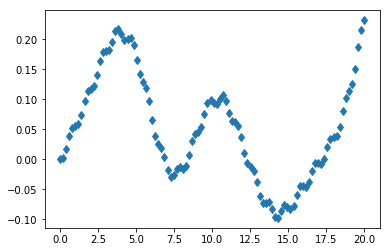

In [15]:
plt.plot(times/365.24,(xerr*1e6)/4,"d")

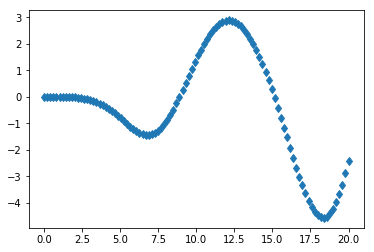

In [12]:
plt.plot(times/365.24,(yerr*1e6)/4,"d")